In [ ]:
# Also added currency data and bond yields since original

In [1]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

Using TensorFlow backend.


In [2]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,TLRY.Low,TLRY.Close,TLRY.Volume,TLRY.Adjusted,MU.Open,MU.High,MU.Low,MU.Close,MU.Volume,MU.Adjusted
863,2019-06-10,182.250000,184.850006,182.210007,183.149994,41385300,183.149994,210.250000,216.940002,209.009995,...,41.029999,43.139999,7322600,43.139999,34.599998,35.540001,34.520000,34.939999,21728000,34.939999
864,2019-06-11,185.059998,185.399994,182.779999,183.399994,41260300,183.399994,219.139999,220.899994,213.500000,...,40.139999,40.490002,2898900,40.490002,35.799999,35.990002,34.750000,34.840000,19208600,34.840000
865,2019-06-12,182.899994,183.279999,182.000000,182.339996,27758100,182.339996,222.949997,223.380005,209.000000,...,39.430000,41.820000,1702500,41.820000,34.009998,34.099998,32.730000,32.959999,28746500,32.959999
866,2019-06-13,183.100006,183.869995,182.740005,183.419998,23715800,183.419998,210.380005,214.899994,207.509995,...,40.400002,40.700001,1167200,40.700001,33.080002,33.639999,33.009998,33.380001,16586700,33.380001
867,2019-06-14,182.479996,183.110001,181.940002,182.639999,22834000,182.639999,211.250000,216.649994,210.399994,...,38.700001,39.009998,1368200,39.009998,32.450001,32.840000,32.240002,32.660000,19700800,32.660000


In [3]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data_orig.tail()

,Index,volatilityQQQ,volatilityTSLA,volatilityMSFT,volatilityINTC,volatilityAAPL,volatilityNFLX,volatilityAMZN,volatilityFB,volatilityGOOG,...,volatilityXLY,volatilityXLP,volatilityXLV,volatilityXLF,volatilityXLK,volatilityXTL,volatilityXLU,volatilityXLRE,volatilityTLRY,volatilityMU
863,2019-06-10,0.262443,0.574566,0.333510,0.253769,0.281142,0.381002,0.409732,0.517354,0.406953,...,0.202950,0.150711,0.130785,0.183441,0.267121,0.202553,0.168077,0.155938,1.063379,0.412362
864,2019-06-11,0.253383,0.573597,0.326130,0.252188,0.269323,0.369345,0.404458,0.531756,0.402374,...,0.187672,0.134942,0.109451,0.181765,0.260561,0.200543,0.150839,0.130113,1.092160,0.414424
865,2019-06-12,0.259465,0.628408,0.331261,0.266931,0.278214,0.377129,0.405765,0.535325,0.401467,...,0.189846,0.136326,0.109338,0.192895,0.268465,0.203165,0.158621,0.129671,1.072741,0.527995
866,2019-06-13,0.231038,0.605956,0.304988,0.239902,0.232847,0.353386,0.375983,0.518845,0.404909,...,0.156865,0.076984,0.091795,0.159182,0.234898,0.125690,0.158864,0.127678,1.070979,0.517080
867,2019-06-14,0.172617,0.533444,0.202580,0.234044,0.224527,0.340522,0.205248,0.225017,0.167734,...,0.131051,0.074474,0.099594,0.159437,0.207356,0.149072,0.159537,0.127758,0.946152,0.533473


In [4]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .rename(columns={'Index_x':'Index'})

In [5]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    df = df.set_index("DATE")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    print(series)
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [6]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")
DAAA = df_from_fred("DAAA")
time.sleep(5)
USSLIND = df_from_fred("USSLIND")
time.sleep(5)
IRLTLT01USM156N = df_from_fred("IRLTLT01USM156N")
time.sleep(5)

CPGDPAI = df_from_fred("CPGDPAI")
time.sleep(5)
DCOILWTICO = df_from_fred("DCOILWTICO")
time.sleep(5)
PNRGINDEXM = df_from_fred("PNRGINDEXM")
time.sleep(5)
PCU3121123121120 = df_from_fred("PCU3121123121120")
time.sleep(5)

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

# Add Next
# CPGDPAI - pct change in GDP
# DCOILWTICO - daily crude oil
# PNRGINDEXM - energy global price index
# PCU3121123121120 - bottled water

GDPC1
M2
CPALTT01USQ657N
PPIACO
UMCSENT
PAYEMS
RRSFS
HOUST
ISRATIO
SP500
FEDFUNDS
UNRATE
T10Y2Y
CBBTCUSD
IPMAN
MPU9900063
PCU33443344
MEHOINUSA672N
TCMDO
FGTCMDODNS
ADSLFAA027N
NCBCMDPMVCE
FGCCSAQ027S
ASTNITA
PCETRIM12M159SFRBDAL
DAAA
USSLIND
IRLTLT01USM156N
CPGDPAI
DCOILWTICO
PNRGINDEXM
PCU3121123121120


In [7]:
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,volatilityXLY,volatilityXLP,volatilityXLV,volatilityXLF,volatilityXLK,volatilityXTL,volatilityXLU,volatilityXLRE,volatilityTLRY,volatilityMU
863,2019-06-10,182.250000,184.850006,182.210007,183.149994,41385300,183.149994,210.250000,216.940002,209.009995,...,0.202950,0.150711,0.130785,0.183441,0.267121,0.202553,0.168077,0.155938,1.063379,0.412362
864,2019-06-11,185.059998,185.399994,182.779999,183.399994,41260300,183.399994,219.139999,220.899994,213.500000,...,0.187672,0.134942,0.109451,0.181765,0.260561,0.200543,0.150839,0.130113,1.092160,0.414424
865,2019-06-12,182.899994,183.279999,182.000000,182.339996,27758100,182.339996,222.949997,223.380005,209.000000,...,0.189846,0.136326,0.109338,0.192895,0.268465,0.203165,0.158621,0.129671,1.072741,0.527995
866,2019-06-13,183.100006,183.869995,182.740005,183.419998,23715800,183.419998,210.380005,214.899994,207.509995,...,0.156865,0.076984,0.091795,0.159182,0.234898,0.125690,0.158864,0.127678,1.070979,0.517080
867,2019-06-14,182.479996,183.110001,181.940002,182.639999,22834000,182.639999,211.250000,216.649994,210.399994,...,0.131051,0.074474,0.099594,0.159437,0.207356,0.149072,0.159537,0.127758,0.946152,0.533473


In [8]:
data_orig2 = data_orig\
  .join(GDPC1)\
  .join(M2)\
  .join(CPALTT01USQ657N)\
  .join(PPIACO)\
  .join(UMCSENT)\
  .join(PAYEMS)\
  .join(RRSFS)\
  .join(HOUST)\
  .join(ISRATIO)\
  .join(SP500)\
  .join(FEDFUNDS)\
  .join(UNRATE)\
  .join(T10Y2Y)\
  .join(CBBTCUSD)\
  .join(IPMAN)\
  .join(MPU9900063)\
  .join(PCU33443344)\
  .join(MEHOINUSA672N)\
  .join(TCMDO)\
  .join(FGTCMDODNS)\
  .join(ADSLFAA027N)\
  .join(NCBCMDPMVCE)\
  .join(FGCCSAQ027S)\
  .join(ASTNITA)\
  .join(PCETRIM12M159SFRBDAL)\
  .join(DAAA)\
  .join(USSLIND)\
  .join(IRLTLT01USM156N)\
  .join(CPGDPAI)\
  .join(DCOILWTICO)\
  .join(PNRGINDEXM)\
  .join(PCU3121123121120)\
  .fillna(method="ffill")\
  .fillna(-1)
data_orig2.head()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,FGCCSAQ027S,ASTNITA,PCETRIM12M159SFRBDAL,DAAA,USSLIND,IRLTLT01USM156N,CPGDPAI,DCOILWTICO,PNRGINDEXM,PCU3121123121120
0,2016-01-04,109.449997,109.599998,108.120003,109.500000,50807600,106.223091,230.720001,231.380005,219.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2016-01-05,110.040001,110.180000,108.800003,109.309998,38795200,106.038773,226.360001,226.889999,220.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2016-01-06,107.410004,108.889999,107.410004,108.260002,41891100,105.020172,220.000000,220.050003,215.979996,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2016-01-07,105.949997,107.290001,104.809998,104.870003,61386300,101.731651,214.190002,218.440002,213.669998,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2016-01-08,105.629997,106.290001,103.900002,104.010002,69344000,100.897369,217.860001,220.440002,210.770004,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [9]:
data_orig2.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,FGCCSAQ027S,ASTNITA,PCETRIM12M159SFRBDAL,DAAA,USSLIND,IRLTLT01USM156N,CPGDPAI,DCOILWTICO,PNRGINDEXM,PCU3121123121120
863,2019-06-10,182.250000,184.850006,182.210007,183.149994,41385300,183.149994,210.250000,216.940002,209.009995,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
864,2019-06-11,185.059998,185.399994,182.779999,183.399994,41260300,183.399994,219.139999,220.899994,213.500000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
865,2019-06-12,182.899994,183.279999,182.000000,182.339996,27758100,182.339996,222.949997,223.380005,209.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
866,2019-06-13,183.100006,183.869995,182.740005,183.419998,23715800,183.419998,210.380005,214.899994,207.509995,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
867,2019-06-14,182.479996,183.110001,181.940002,182.639999,22834000,182.639999,211.250000,216.649994,210.399994,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [10]:
# data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [11]:
list(data_orig2.columns)

['Index',
 'QQQ.Open',
 'QQQ.High',
 'QQQ.Low',
 'QQQ.Close',
 'QQQ.Volume',
 'QQQ.Adjusted',
 'TSLA.Open',
 'TSLA.High',
 'TSLA.Low',
 'TSLA.Close',
 'TSLA.Volume',
 'TSLA.Adjusted',
 'MSFT.Open',
 'MSFT.High',
 'MSFT.Low',
 'MSFT.Close',
 'MSFT.Volume',
 'MSFT.Adjusted',
 'INTC.Open',
 'INTC.High',
 'INTC.Low',
 'INTC.Close',
 'INTC.Volume',
 'INTC.Adjusted',
 'AAPL.Open',
 'AAPL.High',
 'AAPL.Low',
 'AAPL.Close',
 'AAPL.Volume',
 'AAPL.Adjusted',
 'NFLX.Open',
 'NFLX.High',
 'NFLX.Low',
 'NFLX.Close',
 'NFLX.Volume',
 'NFLX.Adjusted',
 'AMZN.Open',
 'AMZN.High',
 'AMZN.Low',
 'AMZN.Close',
 'AMZN.Volume',
 'AMZN.Adjusted',
 'FB.Open',
 'FB.High',
 'FB.Low',
 'FB.Close',
 'FB.Volume',
 'FB.Adjusted',
 'GOOG.Open',
 'GOOG.High',
 'GOOG.Low',
 'GOOG.Close',
 'GOOG.Volume',
 'GOOG.Adjusted',
 'SQ.Open',
 'SQ.High',
 'SQ.Low',
 'SQ.Close',
 'SQ.Volume',
 'SQ.Adjusted',
 'TWTR.Open',
 'TWTR.High',
 'TWTR.Low',
 'TWTR.Close',
 'TWTR.Volume',
 'TWTR.Adjusted',
 'DATA.Open',
 'DATA.High',
 '

In [12]:
data_orig = data_orig2.set_index("Index")

In [13]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if (('Open' in i[1]) or ("volatility" in i[1]))])
ticker_lookup

{'AAPL': 24,
 'AMD': 72,
 'AMZN': 36,
 'BABA': 192,
 'BP': 198,
 'BUD': 204,
 'DATA': 66,
 'DIS': 150,
 'DUK': 162,
 'FB': 42,
 'GLD': 180,
 'GLW': 210,
 'GOOG': 48,
 'HD': 156,
 'INTC': 18,
 'JNJ': 108,
 'JWN': 96,
 'KO': 114,
 'MSFT': 12,
 'MU': 318,
 'NFLX': 30,
 'NVDA': 132,
 'PANW': 126,
 'PFE': 216,
 'PG': 102,
 'QQQ': 0,
 'RHT': 138,
 'SBUX': 78,
 'SFIX': 222,
 'SLV': 186,
 'SPOT': 168,
 'SQ': 54,
 'STX': 228,
 'T': 234,
 'TGT': 90,
 'TLRY': 312,
 'TSLA': 6,
 'TWTR': 60,
 'USO': 144,
 'V': 240,
 'VRSN': 120,
 'WDC': 174,
 'WMT': 84,
 'XLB': 252,
 'XLE': 246,
 'XLF': 282,
 'XLI': 258,
 'XLK': 288,
 'XLP': 270,
 'XLRE': 306,
 'XLU': 300,
 'XLV': 276,
 'XLY': 264,
 'XTL': 294,
 'volatilityAAPL': 328,
 'volatilityAMD': 336,
 'volatilityAMZN': 330,
 'volatilityBABA': 356,
 'volatilityBP': 357,
 'volatilityBUD': 358,
 'volatilityDATA': 335,
 'volatilityDIS': 349,
 'volatilityDUK': 351,
 'volatilityFB': 331,
 'volatilityGLD': 354,
 'volatilityGLW': 359,
 'volatilityGOOG': 332,
 'volati

In [14]:
days_lookback = -1
# pct_df = data_orig.iloc[:,1:].shift(days_lookback).dropna() # Assuming Index dropped since index
pct_df = data_orig.shift(days_lookback).dropna()
pct_df

,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,TSLA.Close,...,FGCCSAQ027S,ASTNITA,PCETRIM12M159SFRBDAL,DAAA,USSLIND,IRLTLT01USM156N,CPGDPAI,DCOILWTICO,PNRGINDEXM,PCU3121123121120
Index,,,,,,,,,,,,,,,,,,,,,
2016-01-04,110.040001,110.180000,108.800003,109.309998,38795200.0,106.038773,226.360001,226.889999,220.000000,223.429993,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-05,107.410004,108.889999,107.410004,108.260002,41891100.0,105.020172,220.000000,220.050003,215.979996,219.039993,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-06,105.949997,107.290001,104.809998,104.870003,61386300.0,101.731651,214.190002,218.440002,213.669998,215.649994,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-07,105.629997,106.290001,103.900002,104.010002,69344000.0,100.897369,217.860001,220.440002,210.770004,211.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-08,104.750000,105.059998,102.730003,104.330002,49767900.0,101.207802,214.009995,214.449997,203.000000,207.850006,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-11,105.330002,106.080002,104.080002,105.540001,46734200.0,102.381592,211.600006,213.740005,205.309998,209.970001,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-12,105.970001,106.230003,101.739998,101.900002,69870700.0,98.850510,212.009995,212.649994,200.000000,200.309998,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-13,102.300003,104.980003,100.669998,104.070000,78445700.0,100.955582,202.210007,210.000000,193.380005,206.179993,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2016-01-14,100.620003,101.940002,99.510002,100.839996,91443900.0,97.822235,198.970001,205.070007,197.250000,204.990005,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [15]:
pct_df.shape

(867, 410)

In [16]:
# data_orig.drop("DATE", axis=1, inplace=True)
# pct_df.drop("DATE", axis=1, inplace=True)
# data_orig.drop("Index", axis=1, inplace=True)
# pct_df.drop("Index", axis=1, inplace=True)

In [17]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
inv_map

{'AAPL.Open': 4,
 'AMD.Open': 12,
 'AMZN.Open': 6,
 'BABA.Open': 32,
 'BP.Open': 33,
 'BUD.Open': 34,
 'DATA.Open': 11,
 'DIS.Open': 25,
 'DUK.Open': 27,
 'FB.Open': 7,
 'GLD.Open': 30,
 'GLW.Open': 35,
 'GOOG.Open': 8,
 'HD.Open': 26,
 'INTC.Open': 3,
 'JNJ.Open': 18,
 'JWN.Open': 16,
 'KO.Open': 19,
 'MSFT.Open': 2,
 'MU.Open': 53,
 'NFLX.Open': 5,
 'NVDA.Open': 22,
 'PANW.Open': 21,
 'PFE.Open': 36,
 'PG.Open': 17,
 'QQQ.Open': 0,
 'RHT.Open': 23,
 'SBUX.Open': 13,
 'SFIX.Open': 37,
 'SLV.Open': 31,
 'SPOT.Open': 28,
 'SQ.Open': 9,
 'STX.Open': 38,
 'T.Open': 39,
 'TGT.Open': 15,
 'TLRY.Open': 52,
 'TSLA.Open': 1,
 'TWTR.Open': 10,
 'USO.Open': 24,
 'V.Open': 40,
 'VRSN.Open': 20,
 'WDC.Open': 29,
 'WMT.Open': 14,
 'XLB.Open': 42,
 'XLE.Open': 41,
 'XLF.Open': 47,
 'XLI.Open': 43,
 'XLK.Open': 48,
 'XLP.Open': 45,
 'XLRE.Open': 51,
 'XLU.Open': 50,
 'XLV.Open': 46,
 'XLY.Open': 44,
 'XTL.Open': 49,
 'volatilityAAPL.Open': 58,
 'volatilityAMD.Open': 66,
 'volatilityAMZN.Open': 60,
 '

In [18]:
print("target", pct_df.shape)
print("features", data_orig.iloc[0:(data_orig.shape[0] - 1),:].shape)

target (867, 410)
features (867, 410)


In [35]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig.iloc[0:(data_orig.shape[0] - 1),:])

# Normalized data
scaler = MinMaxScaler(feature_range=(0, 1))
data_mat = scaler.fit_transform(data_orig_detrended)
pctdf_mat = scaler.transform(pct_df)

# Non-normalized version
# data_mat = data_orig_detrended
# pctdf_mat = pct_df.as_matrix()

In [36]:
print(data_mat.shape)
print(pct_df.shape)
print(pctdf_mat.shape)

(867, 410)
(867, 410)
(867, 410)


In [37]:
seq_len = 30 # days to use for prediction
data = np.array((data_mat))

In [38]:
data.shape

(867, 410)

In [39]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)
row = round(0.9 * result.shape[0])

In [40]:
pctdf_mat = pctdf_mat[sequence_length:]
pctdf_mat.shape

(836, 410)

In [41]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = pctdf_mat[:int(row)] # Needs to be N-day shift
x_test = result[int(row):, :]
y_test = pctdf_mat[int(row):]  # Needs to be N-day shift

[x_train, y_train, x_test, y_test]

[array([[[0.56609214, 0.56608362, 0.56607544, ..., 0.64688242,
          0.64608999, 0.64530268],
         [0.71711676, 0.71714721, 0.71717801, ..., 0.69001051,
          0.68832337, 0.68664713],
         [0.61332093, 0.61333848, 0.61335622, ..., 0.67328474,
          0.67220223, 0.67112671],
         ...,
         [0.64437158, 0.64425404, 0.64413617, ..., 0.54714814,
          0.54598918, 0.54483772],
         [0.64795415, 0.64787178, 0.64778922, ..., 0.58048258,
          0.57927666, 0.57807855],
         [0.62325718, 0.62321538, 0.62317337, ..., 0.6176194 ,
          0.61652461, 0.61543689]],
 
        [[0.71711676, 0.71714721, 0.71717801, ..., 0.69001051,
          0.68832337, 0.68664713],
         [0.61332093, 0.61333848, 0.61335622, ..., 0.67328474,
          0.67220223, 0.67112671],
         [0.45157148, 0.4516311 , 0.45169117, ..., 0.7062645 ,
          0.70607718, 0.70589107],
         ...,
         [0.64795415, 0.64787178, 0.64778922, ..., 0.58048258,
          0.57927666, 0.

In [42]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(752, 31, 410)
(752, 410)
(84, 31, 410)
(84, 410)


In [43]:
from keras.layers import Input, Dense
from keras.models import Model
LAYERS = 30

# This is likely the culprit for why the nextwork isn't converging
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = LSTM(output_dim=LAYERS, kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = LSTM(LAYERS, kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=False)(x)
x = BatchNormalization()(x)
predictions = Dense(output_dim=y_train.shape[1], activation='linear')(x)

start = time.time()
model = Model(inputs=inputs, outputs=predictions)
adam = Adam(lr=0.1)
model.compile(loss='mse', optimizer=adam)
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(kernel_regularizer=<keras.reg..., return_sequences=True, units=30)`
  import sys


compilation time :  0.021191120147705078


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=410)`
  # This is added back by InteractiveShellApp.init_path()


In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 31, 410)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 31, 30)            52920     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 30)            120       
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 410)               12710     
Total params: 73,190
Trainable params: 73,070
Non-trainable params: 120
_________________________________________________________________


In [45]:
MODELNAME = 'multiplemodeltest_medusa_itemized_6-15-2019v1.0.1_normalized'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1, epsilon=1e-4, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
tbrd = TensorBoard(log_dir='./models/logs', histogram_freq=0, batch_size=150, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [46]:
# Function to display the target and prediciton
def testmodel(epoch, logs):
    days = 5
    t = "QQQ"
    plt.style.use('fivethirtyeight')
    plt.title(t+" "+str(epoch))
    plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
    plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
    plt.show()

    plt.title("Volatility "+t+" "+str(epoch))
    plt.plot([i[ticker_lookup["volatility"+t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))])
    plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
    plt.show()

testmodelcb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [49]:
# model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5')
EPOCHS = 500
VALIDATIONSIZE = 0.10
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')
reduce_lr_loss_training = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')
history = model.fit(
    x_train,
    y_train,
    batch_size=100,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, mcp_save, reduce_lr_loss_training, tbrd],
    shuffle=True)

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 676 samples, validate on 76 samples
Epoch 1/500
676/676 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 2/500
676/676 [==============================] - 1s 937us/step - loss: 0.0013 - val_loss: 0.0059
Epoch 3/500
676/676 [==============================] - 1s 932us/step - loss: 0.0013 - val_loss: 0.0055
Epoch 4/500
676/676 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 5/500
676/676 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 6/500
676/676 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0043

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
Epoch 7/500
676/676 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 8/500
676/676 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 9/500
676/676 [==============================] - 1s 1ms/st

KeyboardInterrupt: 

In [50]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [51]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 31, 410)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 31, 30)            52920     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 30)            120       
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 410)               12710     
Total params: 73,190
Trainable params: 73,070
Non-trainable params: 120
_________________________________________________________________


In [52]:
best_model.evaluate(x_test, y_test)

84/84 [==============================] - 0s 5ms/step


0.0011096063812839844

In [95]:
#(days, 31, data.shape[1]) # (5, 31, 410)
# best_model.predict(np.reshape(x_test[-5:], (5, 31, data.shape[1]))) #works

array([[1.156205  , 1.1561776 , 1.1546386 , ..., 0.81625223, 0.8101229 ,
        0.80575216],
       [1.156205  , 1.1561776 , 1.1546386 , ..., 0.81625223, 0.8101229 ,
        0.80575216],
       [1.156205  , 1.1561776 , 1.1546386 , ..., 0.81625223, 0.8101229 ,
        0.80575216],
       [1.156205  , 1.1561776 , 1.1546386 , ..., 0.81625223, 0.8101229 ,
        0.80575216],
       [1.156205  , 1.1561776 , 1.1546386 , ..., 0.81625223, 0.8101229 ,
        0.80575216]], dtype=float32)

In [53]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

In [ ]:
# for t in list(ticker_lookup.keys()):
#     plt.style.use('fivethirtyeight')
#     plt.title(str(t)+" for week of "+"06-10-2019")
#     plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(x_train[-days:], (days, x_train.shape[1], x_train.shape[2])))])
#     plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
#     if "volatility" in t:
#         plt.savefig('../reports/'+t.split("volatility")[1]+'_volatility_prediction.png')
#     else:
#         plt.savefig('../reports/'+t+'_prediction.png')
#     plt.show()

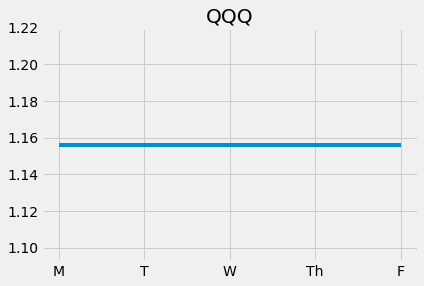

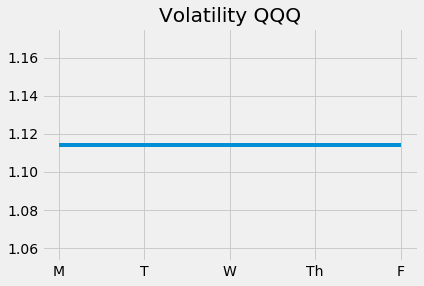

In [96]:
t = "QQQ"
plt.style.use('fivethirtyeight')
plt.title(t)
plt.plot([i[ticker_lookup[t]] for i in best_model.predict(np.reshape(x_test[-5:], (5, 31, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

plt.title("Volatility "+t)
plt.plot([i[ticker_lookup["volatility"+t]] for i in best_model.predict(np.reshape(x_test[-5:], (5, 31, data.shape[1])))])
plt.xticks(np.arange(5), ('M', 'T', 'W', 'Th', 'F'))
plt.show()

In [ ]:
def maxProfit(prices, n, k): 
      
    # Bottom-up DP approach 
    profit = [[0 for i in range(k + 1)] 
                 for j in range(n)] 
      
    # Profit is zero for the first 
    # day and for zero transactions 
    for i in range(1, n): 
          
        for j in range(1, k + 1): 
            max_so_far = 0
              
            for l in range(i): 
                max_so_far = max(max_so_far, prices[i] -
                            prices[l] + profit[l][j - 1]) 
                              
            profit[i][j] = max(profit[i - 1][j], max_so_far) 
      
    return profit[n - 1][k] 
  
# Driver code 
k = 2
prices = [i[ticker_lookup[t]] for i in best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))]
n = len(prices) 
  
print("Maximum profit is:", 
       maxProfit(prices, n, k)) 